In [229]:
import numpy as np
import pandas as pd
import datetime as dt
from app import db, WalliStat
import plotly.graph_objs as go       
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"  #"plotly_white" 

In [230]:
db.create_all()

## Read back `hourly` data from database

In [231]:
wss = db.session.query(WalliStat).filter(WalliStat.campaign_id==0).all()
df = WalliStat.to_dataframe(wss)
df.tail(2)

,datetime,charging_state,I_L1,I_L2,I_L3,temperature,V_L1,V_L2,V_L3,extern_lock_state,power,energy_pwr_on,energy_total,I_max_cfg,I_min_cfg,modbus_watchdog_timeout,remote_lock,I_max_cmd,I_fail_safe,campaign_id
id,,,,,,,,,,,,,,,,,,,,
1388,2021-11-09 19:00:00,7,10.4,9.9,9.2,21.2,233,232,236,1,6947,377842,558521,10,10,15000,1,100,100,0
1389,2021-11-09 20:00:00,7,10.5,9.8,9.2,21.4,232,231,234,1,6897,384675,565354,10,10,15000,1,100,100,0


## Remove non-useful columns

In [232]:
df.columns

Index(['datetime', 'charging_state', 'I_L1', 'I_L2', 'I_L3', 'temperature',
       'V_L1', 'V_L2', 'V_L3', 'extern_lock_state', 'power', 'energy_pwr_on',
       'energy_total', 'I_max_cfg', 'I_min_cfg', 'modbus_watchdog_timeout',
       'remote_lock', 'I_max_cmd', 'I_fail_safe', 'campaign_id'],
      dtype='object')

In [233]:
df = df.drop(['I_L1', 'I_L2', 'I_L3', 'V_L1', 'V_L2', 'V_L3', 'extern_lock_state', 
              'energy_pwr_on', 'I_max_cfg', 'I_min_cfg', 'modbus_watchdog_timeout', 
              'remote_lock', 'I_max_cmd', 'I_fail_safe', 'campaign_id'], axis=1).set_index("datetime")
df.tail()

,charging_state,temperature,power,energy_total
datetime,,,,
2021-11-09 16:00:00,2,16.7,0,544909
2021-11-09 17:00:00,2,16.1,0,544909
2021-11-09 18:00:00,7,20.2,6898,551630
2021-11-09 19:00:00,7,21.2,6947,558521
2021-11-09 20:00:00,7,21.4,6897,565354


## Scale to kW and kWh

In [234]:
df["power_kW"] = df["power"] / 1000
df["energy_kWh"] = df["energy_total"] / 1000
df = df.drop(["power", "energy_total"], axis=1)
df.tail()

,charging_state,temperature,power_kW,energy_kWh
datetime,,,,
2021-11-09 16:00:00,2,16.7,0.0,544.909
2021-11-09 17:00:00,2,16.1,0.0,544.909
2021-11-09 18:00:00,7,20.2,6.898,551.63
2021-11-09 19:00:00,7,21.2,6.947,558.521
2021-11-09 20:00:00,7,21.4,6.897,565.354


In [235]:
df.columns

Index(['charging_state', 'temperature', 'power_kW', 'energy_kWh'], dtype='object')

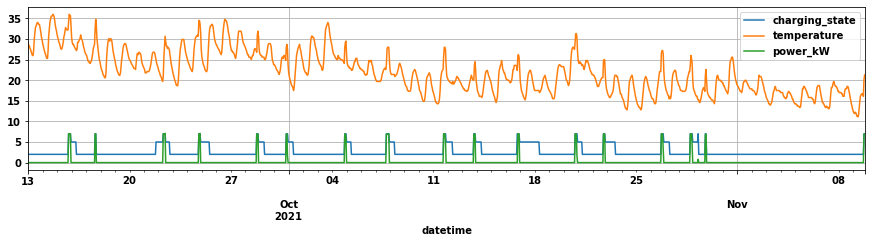

In [236]:
df[['charging_state', 'temperature', 'power_kW']].plot(figsize=(15,3), grid="both");

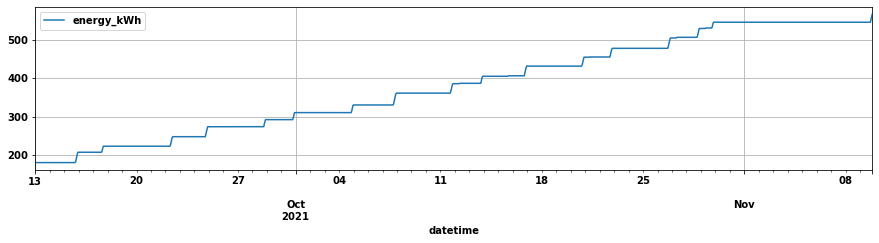

In [237]:
df[["energy_kWh"]].plot(figsize=(15,3), grid="both");

In [238]:
df.shape

(1389, 4)

## Calculated delta Energy

In [239]:
df["charged_kWh"] = df["energy_kWh"].diff()
df.head()

,charging_state,temperature,power_kW,energy_kWh,charged_kWh
datetime,,,,,
2021-09-13 00:00:00,2,28.9,0.0,180.679,NaN
2021-09-13 01:00:00,2,28.3,0.0,180.679,0.0
2021-09-13 02:00:00,2,28.3,0.0,180.679,0.0
2021-09-13 03:00:00,2,27.7,0.0,180.679,0.0
2021-09-13 04:00:00,2,27.5,0.0,180.679,0.0


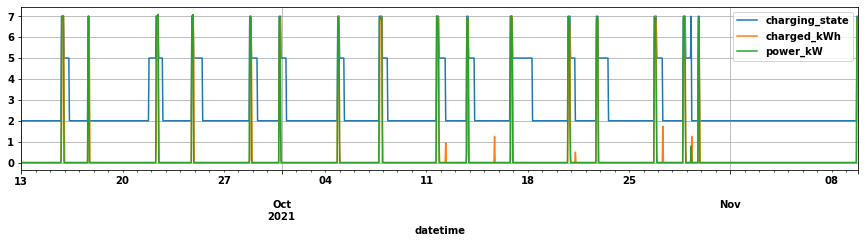

In [240]:
df[['charging_state', 'charged_kWh', "power_kW"]].plot(figsize=(15,3), grid="both");

## Analyze `charged_kWh` spikes

In [241]:
pd.options.display.min_rows = 100


In [242]:
pd.set_option('display.max_rows', 101)

In [243]:
df[df.index.date == dt.date(2021, 10, 29)]

,charging_state,temperature,power_kW,energy_kWh,charged_kWh
datetime,,,,,
2021-10-29 00:00:00,5,17.5,0.0,528.674,0.0
2021-10-29 01:00:00,5,17.3,0.0,528.674,0.0
2021-10-29 02:00:00,5,16.7,0.0,528.674,0.0
2021-10-29 03:00:00,5,16.4,0.0,528.674,0.0
2021-10-29 04:00:00,5,16.1,0.0,528.674,0.0
2021-10-29 05:00:00,5,16.1,0.0,528.674,0.0
2021-10-29 06:00:00,5,15.5,0.0,528.674,0.0
2021-10-29 07:00:00,7,15.2,0.794,528.676,0.002
2021-10-29 08:00:00,2,15.2,0.0,529.933,1.257


--> `charged_kWh` spikes are explainable. The **parking heater** is used on regular workdays (non home office) in the morning between 7:00 and 8:00. Also those heating periods are shorter than one hour, so they don't necessarily show up in the `power_kW` signal. 

## Create a Github-like maps

In [244]:
df["date"] = [idx.date() for idx in df.index]
df["weekday"] = [idx.day_of_week for idx in df.index]
df["week"] = [idx.weekofyear for idx in df.index]
df["month"] = [idx.month for idx in df.index]
df.sample(6)

,charging_state,temperature,power_kW,energy_kWh,charged_kWh,date,weekday,week,month
datetime,,,,,,,,,
2021-10-29 06:00:00,5,15.5,0.0,528.674,0.0,2021-10-29,4,43,10
2021-10-05 05:00:00,5,22.9,0.0,330.175,0.0,2021-10-05,1,40,10
2021-10-11 06:00:00,2,14.3,0.0,360.875,0.0,2021-10-11,0,41,10
2021-09-21 02:00:00,2,21.8,0.0,223.168,0.0,2021-09-21,1,38,9
2021-09-22 19:00:00,2,26.2,0.0,247.861,0.0,2021-09-22,2,38,9
2021-10-09 17:00:00,2,22.6,0.0,360.875,0.0,2021-10-09,5,40,10


In [245]:
zeros = pd.DataFrame(columns=np.arange(1, 53, dtype=int), data=np.zeros(shape=(7, 52)))
wks = df.pivot_table(index="weekday", columns="week", values="charged_kWh", aggfunc="sum") + zeros
wks.iloc[:,35:45]

,36,37,38,39,40,41,42,43,44,45
weekday,,,,,,,,,,
0,NaN,0.000,0.000,0.000,18.800,24.526,0.000,0.000,0.0,0.000
1,NaN,0.000,0.000,18.417,1.026,0.947,0.000,26.840,0.0,20.445
2,NaN,26.832,24.693,0.000,0.000,18.283,23.187,1.735,0.0,NaN
3,NaN,0.000,0.000,18.232,30.700,0.000,0.499,22.948,0.0,NaN
4,NaN,15.657,25.839,0.000,0.000,1.249,22.473,16.235,0.0,NaN
5,NaN,0.000,0.000,0.000,0.000,25.112,0.000,0.000,0.0,NaN
6,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,NaN


In [246]:
fig = px.imshow(wks, labels={"x": "calender week", "y": "", "color": "charged_kWh"},
                color_continuous_scale='Greens', width=1000, height=300)
fig.update_layout(yaxis = {"tickmode": 'array',
                           "tickvals": [ 0,    1,    2,    3,    4,    5,    6  ],
                           "ticktext": ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']})
fig.show()

## Create temperature chart

,temperature max,temperature mean,temperature min
date,,,
2021-11-07,19.7,16.204167,13.1
2021-11-08,18.5,16.645833,13.1
2021-11-09,21.4,14.652381,11.1


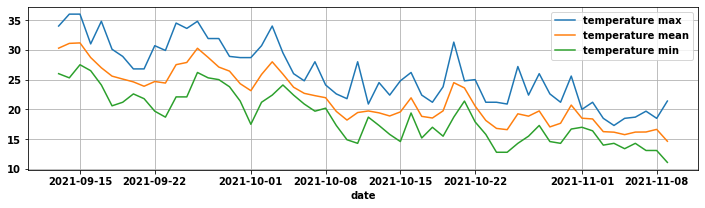

In [252]:
temps = df[["temperature", "date"]].groupby(by="date").agg(["max", "mean", "min"])
temps.columns = [f"temperature {c}" for c in temps.columns.droplevel()]
temps.plot(figsize=(12,3), grid="both");
temps.tail(3)

In [248]:
fig = go.Figure()
for col in temps.columns:
    fig.add_trace(go.Scatter(x=temps.index, y=temps[col], name=col))
fig.update_layout(width=800, height=200, margin=dict(l=10, r=10, b=10, t=10))
fig.show()

## charging trend

In [249]:
kwh = df[["date", "charged_kWh"]].groupby("date").agg("sum")
kwh["rolling_mean"] = kwh["charged_kWh"].rolling(10, win_type="triang", center=True).mean()
kwh["mean"] = [kwh.charged_kWh.mean()] * kwh.shape[0]
kwh.tail()

,charged_kWh,rolling_mean,mean
date,,,
2021-11-05,0.000,0.4089,6.632328
2021-11-06,0.000,NaN,6.632328
2021-11-07,0.000,NaN,6.632328
2021-11-08,0.000,NaN,6.632328
2021-11-09,20.445,NaN,6.632328


In [250]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=kwh.index, y=kwh.charged_kWh, mode="markers", name="charged_kWh"))
fig.add_trace(go.Scatter(x=kwh.index, y=kwh.rolling_mean, name="rolling_mean"))
fig.add_trace(go.Scatter(x=kwh.index, y=kwh["mean"], name="mean"))
fig.update_layout(width=800, height=200, margin=dict(l=10, r=10, b=10, t=10))
fig.show();